In [3]:
from datasets import load_dataset

spanish_dataset = load_dataset("amazon_reviews_multi", "es")
english_dataset = load_dataset("amazon_reviews_multi", "en")
english_dataset

Found cached dataset amazon_reviews_multi (C:/Users/Raj/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset amazon_reviews_multi (C:/Users/Raj/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

In [7]:
# let's sample the dataset
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['review_title']}")
        print(f"\n'>> Review: {example['review_body']}")
        
show_samples(english_dataset)

Loading cached shuffled indices for dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-0b126a62dc97ecba.arrow



'>> Title: Worked in front position, not rear

'>> Review: 3 stars because these are not rear brakes as stated in the item description. At least the mount adapter only worked on the front fork of the bike that I got it for.

'>> Title: meh

'>> Review: Does it’s job and it’s gorgeous but mine is falling apart, I had to basically put it together again with hot glue

'>> Title: Can't beat these for the money

'>> Review: Bought this for handling miscellaneous aircraft parts and hanger "stuff" that I needed to organize; it really fit the bill. The unit arrived quickly, was well packaged and arrived intact (always a good sign). There are five wall mounts-- three on the top and two on the bottom. I wanted to mount it on the wall, so all I had to do was to remove the top two layers of plastic drawers, as well as the bottom corner drawers, place it when I wanted and mark it; I then used some of the new plastic screw in wall anchors (the 50 pound variety) and it easily mounted to the wall. So

In [8]:
# training a summarization model on all 400k examples will take a long time on a single GPU.
# Let's focus on a single domain of products

english_dataset.set_format("pandas")
english_df = english_dataset["train"][:]
# show counts for top 20 product categories
english_df["product_category"].value_counts()[:20]

product_category
home                      17679
apparel                   15951
wireless                  15717
other                     13418
beauty                    12091
drugstore                 11730
kitchen                   10382
toy                        8745
sports                     8277
automotive                 7506
lawn_and_garden            7327
home_improvement           7136
pet_products               7082
digital_ebook_purchase     6749
pc                         6401
electronics                6186
office_product             5521
shoes                      5197
grocery                    4730
book                       3756
Name: count, dtype: int64

In [9]:
# let's filter the dataset to only include examples from the "Book" and digital "Ebook" categories from both languages
def filter_books(example):
    return example["product_category"] in ["book", "digital_ebook_purchase"]

In [10]:
# apply the filter to the dataset
# before applying the filter, let's switch the format of english_dataset from "pandas" back to "arrow":
english_dataset.reset_format()

In [11]:
# apply the filter now
spanish_books = spanish_dataset.filter(filter_books)
english_books = english_dataset.filter(filter_books)
show_samples(english_books)

Loading cached processed dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\es\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-0ac36275c34e4cec.arrow
Loading cached processed dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\es\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-adc33e5739600a83.arrow
Loading cached processed dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\es\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-84ce11616b4cb2ad.arrow
Loading cached processed dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-987e3f842ae71c25.arrow
Loading cached processed dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-112c62204eaabee3.a


'>> Title: I'm dissapointed.

'>> Review: I guess I had higher expectations for this book from the reviews. I really thought I'd at least like it. The plot idea was great. I loved Ash but, it just didnt go anywhere. Most of the book was about their radio show and talking to callers. I wanted the author to dig deeper so we could really get to know the characters. All we know about Grace is that she is attractive looking, Latino and is kind of a brat. I'm dissapointed.

'>> Title: Good art, good price, poor design

'>> Review: I had gotten the DC Vintage calendar the past two years, but it was on backorder forever this year and I saw they had shrunk the dimensions for no good reason. This one has good art choices but the design has the fold going through the picture, so it's less aesthetically pleasing, especially if you want to keep a picture to hang. For the price, a good calendar

'>> Title: Helpful

'>> Review: Nearly all the tips useful and. I consider myself an intermediate to adv

In [12]:
# create a bilingual dataset
from datasets import DatasetDict, concatenate_datasets

books_dataset = DatasetDict()

for split in english_books.keys():
    books_dataset[split] = concatenate_datasets([english_books[split], spanish_books[split]])
    books_dataset[split] = books_dataset[split].shuffle(seed=42)
    
# let's check the number of examples in the training set
show_samples(books_dataset)

Loading cached shuffled indices for dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-9679fdd8f546d5f1.arrow
Loading cached shuffled indices for dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-0b9067c857222794.arrow
Loading cached shuffled indices for dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-a653fea01d6b30cd.arrow
Loading cached shuffled indices for dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-6cfc80feb0f00fd3.arrow



'>> Title: Easy to follow!!!!

'>> Review: I loved The dash diet weight loss Solution. Never hungry. I would recommend this diet. Also the menus are well rounded. Try it. Has lots of the information need thanks.

'>> Title: PARCIALMENTE DAÑADO

'>> Review: Me llegó el día que tocaba, junto a otros libros que pedí, pero la caja llegó en mal estado lo cual dañó las esquinas de los libros porque venían sin protección (forro).

'>> Title: no lo he podido descargar

'>> Review: igual que el anterior


<Axes: title={'center': 'Word Count Distribution'}, ylabel='Frequency'>

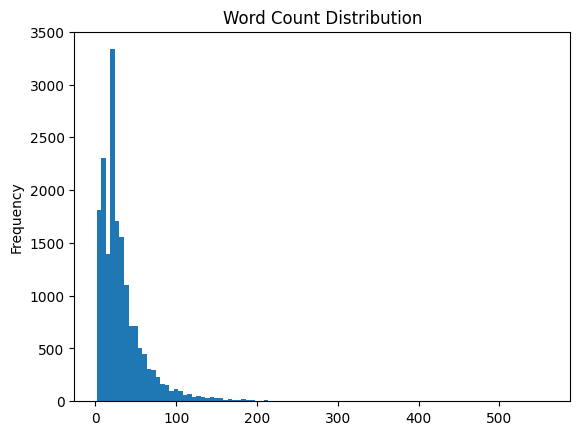

In [13]:
# plot the word count distribution in the books dataset
import matplotlib.pyplot as plt
books_dataset.set_format("pandas")
books_df = books_dataset["train"][:]
books_df["word_count"] = books_df["review_body"].apply(lambda x: len(x.split()))
books_df["word_count"].plot(kind="hist", bins=100, title="Word Count Distribution")

In [14]:
# reset the format of the dataset back to "arrow"
books_dataset.reset_format()

In [15]:
# filter out any titles that are less than 2 words long
books_dataset = books_dataset.filter(lambda x: len(x["review_body"].split()) > 2)

Loading cached processed dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-77effdc904843ac2.arrow


Loading cached processed dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-7386f938fe7aa54b.arrow
Loading cached processed dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-ecaa8a9e86b87984.arrow


In [16]:
# load the tokenizer with the pretrained checkpoint
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

c:\Users\Raj\repos\hf-nlp\.venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [17]:
# test out the mt5 tokenizer on a small example:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
inputs

{'input_ids': tensor([[30273,   261,  1037, 10990,   339, 64712,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [18]:
# decode the tokenized inputs and see what the tokenizer does
tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['▁Hello', ',', '▁my', '▁dog', '▁is', '▁cute', '</s>']

In [19]:
# processing inputs and targets with mt5 tokenizer using text_target to truncate the inputs and targets to a maximum length so they don't exceed the maximum context size of the model

max_input_length = 512
max_target_length = 30

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["review_body"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["review_title"],
        max_length=max_target_length,
        truncation=True,
    )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [20]:
# tokenize the whole corpus using the handy dataset.map() method
# batched=True will ensure that the tokenization happens in batches on the CPU, multithreaded and fast tokenizers in hf transformers to get the most of the preprocessing
tokenized_datasets = books_dataset.map(preprocess_function, batched=True)

Loading cached processed dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-9949e5342d363a6c.arrow
Loading cached processed dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-8acedca0152688d1.arrow
Loading cached processed dataset at C:\Users\Raj\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-067fa938df9e0b81.arrow


In [21]:
# Commonly used metrics for summarization tasks are ROUGE and BLEU
# suppose we want to compare the following two summaries:

generated_summary = "I absolutely loved reading the Hunger games"
reference_summary = "I loved reading the Hunger games"

In [17]:
# First install the rouge_score package
! pip install rouge_score

In [22]:
# load the rouge metric
import evaluate
import datasets

rouge_score = evaluate.load("rouge")
score1 = datasets.load_metric("rouge")

C:\Users\Raj\AppData\Local\Temp\ipykernel_17872\23820399.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  score1 = datasets.load_metric("rouge")


In [23]:
# use the compute method to compute the rouge score at once
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary], use_aggregator=True
)
scores

{'rouge1': 0.923076923076923,
 'rouge2': 0.7272727272727272,
 'rougeL': 0.923076923076923,
 'rougeLsum': 0.923076923076923}

In [24]:
# rouge1 variant is the overlap of unigrams
import pprint
scores1 = score1.compute(
    predictions=[generated_summary], references=[reference_summary], use_aggregator=True
)
scores1

{'rouge1': AggregateScore(low=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), mid=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), high=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923)),
 'rouge2': AggregateScore(low=Score(precision=0.6666666666666666, recall=0.8, fmeasure=0.7272727272727272), mid=Score(precision=0.6666666666666666, recall=0.8, fmeasure=0.7272727272727272), high=Score(precision=0.6666666666666666, recall=0.8, fmeasure=0.7272727272727272)),
 'rougeL': AggregateScore(low=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), mid=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), high=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923)),
 'rougeLsum': AggregateScore(low=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), mid=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.92307692307

Creating a strong baseline

In [21]:
! pip install nltk

In [25]:
# a common baseline for text summarization is to simply take the first three sentences of an article often called the laed-3 baseline. We could use full stops to track the sentence boundaries but this will fail on acronyms like "U.S.A" or "U.K". Instead, we can use the nltk library to split the text into sentences
# download the punctuation rules
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
# import the sentence tokenizer from nltk and create a simple function to extract the first 3 sentences in a review. The convention in text summarization is to separate each summary with a newline, so let's also include this and test it on a training example

from nltk.tokenize import sent_tokenize

def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [27]:
print(three_sentence_summary(books_dataset["train"][0]["review_body"]))

I gave it 4 stars because I felt the beginning chapter was a bit uneven, but as I got into the story, it gripped me.
The characters, location, and the twists kept me reading well into the night.
After posting this review, I'm going back to purchase the next book in the series.


In [28]:
# now implement a function that extracts these summaries from a dataset and computes the ROUGE scores for the baseline

def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(review) for review in dataset["review_body"]]
    return metric.compute(predictions=summaries, references=dataset["review_title"])

In [29]:
# compute the baseline rouge score on the validation set and prettify them a bit using Pandas

import pandas as pd

score = evaluate_baseline(books_dataset["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn] * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 11.69, 'rouge2': 5.79, 'rougeL': 11.01, 'rougeLsum': 11.17}

Fine tuning mt5 with Trainer API

In [30]:
# summarization is a sequence to sequence task and hence loading the auto model for seq2seq
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [31]:
from huggingface_hub import notebook_login
notebook_login()

In [32]:
# we'll need to generate summaries in order to compute ROUGE scores during training. 

from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 8

# show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir= f"{model_name}-finetuned-amazon-en-es",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

In [33]:
# define the metric that we want to use to evaluate the model
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    # compute the ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [34]:
# Data collator for seq2seq tasks will dynamically pad the inputs and labels
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [35]:
# let's see what this data collator produces when we feed it a batch of examples
tokenized_datasets = tokenized_datasets.remove_columns(
    books_dataset["train"].column_names
)

In [36]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 17606
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 423
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 442
    })
})

In [37]:
for i in range(2):
    print(tokenized_datasets["train"][i])

# features = (tokenized_datasets["train"][i] for i in range(2))
# features

{'input_ids': [336, 22161, 609, 419, 11236, 259, 3361, 336, 26766, 287, 259, 43909, 259, 39507, 639, 259, 262, 5485, 335, 25328, 261, 1156, 527, 336, 5666, 2387, 287, 9891, 261, 609, 259, 170946, 345, 416, 260, 486, 48971, 261, 8938, 261, 305, 287, 259, 71822, 263, 259, 49206, 416, 11807, 2857, 2387, 287, 9713, 260, 11076, 45217, 714, 4302, 261, 336, 277, 282, 259, 5846, 3004, 288, 17979, 287, 6844, 3435, 281, 287, 12614, 260, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [336, 277, 282, 66966, 345, 309, 1]}
{'input_ids': [8204, 3435, 288, 4906, 332, 4205, 10608, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1], 'labels': [4983, 1059, 261, 1]}


In [38]:
# pass the tokenized datasets to the data collator; sample the first couple of examples
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[   336,  22161,    609,    419,  11236,    259,   3361,    336,  26766,
            287,    259,  43909,    259,  39507,    639,    259,    262,   5485,
            335,  25328,    261,   1156,    527,    336,   5666,   2387,    287,
           9891,    261,    609,    259, 170946,    345,    416,    260,    486,
          48971,    261,   8938,    261,    305,    287,    259,  71822,    263,
            259,  49206,    416,  11807,   2857,   2387,    287,   9713,    260,
          11076,  45217,    714,   4302,    261,    336,    277,    282,    259,
           5846,   3004,    288,  17979,    287,   6844,   3435,    281,    287,
          12614,    260,      1],
        [  8204,   3435,    288,   4906,    332,   4205,  10608,      1,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,     

From the above output, we have the expected results - 
1. Padding with 0 for PAD token to the right on the inputs of the second sample to be the same size as the longer first sample
2. Labels padded with -100s to ensure the loss function ignores the padding tokens
3. New decoder-input-ids which has shifted the labels to the right by inserting a [PAD] token in the first entry

In [39]:
# we have all the ingredients to instantiate the Trainer 

from transformers import Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

c:\Users\Raj\repos\hf-nlp\7-main-nlp-tasks\mt5-small-finetuned-amazon-en-es is already a clone of https://huggingface.co/RajkNakka/mt5-small-finetuned-amazon-en-es. Make sure you pull the latest changes with `repo.git_pull()`.


In [40]:
trainer.evaluate()

  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 22.781015396118164,
 'eval_rouge1': 0.106,
 'eval_rouge2': 0.0,
 'eval_rougeL': 0.106,
 'eval_rougeLsum': 0.106,
 'eval_runtime': 7.7337,
 'eval_samples_per_second': 54.696,
 'eval_steps_per_second': 6.853}

In [41]:
trainer.train()

c:\Users\Raj\repos\hf-nlp\.venv\Lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/17608 [00:00<?, ?it/s]

{'loss': 6.0643, 'learning_rate': 4.9003180372557925e-05, 'epoch': 1.0}


  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 3.180852174758911, 'eval_rouge1': 9.7343, 'eval_rouge2': 3.3747, 'eval_rougeL': 9.618, 'eval_rougeLsum': 9.5626, 'eval_runtime': 7.1873, 'eval_samples_per_second': 58.854, 'eval_steps_per_second': 7.374, 'epoch': 1.0}
{'loss': 3.6469, 'learning_rate': 4.200636074511586e-05, 'epoch': 2.0}


  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 3.0471205711364746, 'eval_rouge1': 10.6825, 'eval_rouge2': 3.6312, 'eval_rougeL': 10.6077, 'eval_rougeLsum': 10.6607, 'eval_runtime': 7.1909, 'eval_samples_per_second': 58.825, 'eval_steps_per_second': 7.37, 'epoch': 2.0}
{'loss': 3.3978, 'learning_rate': 3.5009541117673784e-05, 'epoch': 3.0}


  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 2.9940688610076904, 'eval_rouge1': 11.3078, 'eval_rouge2': 4.3662, 'eval_rougeL': 11.2585, 'eval_rougeLsum': 11.1503, 'eval_runtime': 7.6058, 'eval_samples_per_second': 55.616, 'eval_steps_per_second': 6.968, 'epoch': 3.0}
{'loss': 3.2626, 'learning_rate': 2.8012721490231714e-05, 'epoch': 4.0}


  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 2.9707508087158203, 'eval_rouge1': 12.0216, 'eval_rouge2': 4.1979, 'eval_rougeL': 11.8896, 'eval_rougeLsum': 11.8944, 'eval_runtime': 7.6386, 'eval_samples_per_second': 55.377, 'eval_steps_per_second': 6.938, 'epoch': 4.0}
{'loss': 3.1728, 'learning_rate': 2.101590186278964e-05, 'epoch': 5.0}


  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 2.9692111015319824, 'eval_rouge1': 12.905, 'eval_rouge2': 4.8062, 'eval_rougeL': 12.8674, 'eval_rougeLsum': 12.8577, 'eval_runtime': 8.0505, 'eval_samples_per_second': 52.544, 'eval_steps_per_second': 6.583, 'epoch': 5.0}
{'loss': 3.1046, 'learning_rate': 1.4019082235347571e-05, 'epoch': 6.0}


  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 2.9618046283721924, 'eval_rouge1': 13.3125, 'eval_rouge2': 5.7428, 'eval_rougeL': 13.2373, 'eval_rougeLsum': 13.223, 'eval_runtime': 8.1513, 'eval_samples_per_second': 51.894, 'eval_steps_per_second': 6.502, 'epoch': 6.0}
{'loss': 3.069, 'learning_rate': 7.022262607905498e-06, 'epoch': 7.0}


  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 2.96435546875, 'eval_rouge1': 13.8965, 'eval_rouge2': 6.0565, 'eval_rougeL': 13.9164, 'eval_rougeLsum': 13.8888, 'eval_runtime': 8.1893, 'eval_samples_per_second': 51.653, 'eval_steps_per_second': 6.472, 'epoch': 7.0}
{'loss': 3.0409, 'learning_rate': 2.5442980463425713e-08, 'epoch': 8.0}


  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 2.9624009132385254, 'eval_rouge1': 13.5483, 'eval_rouge2': 5.8705, 'eval_rougeL': 13.4874, 'eval_rougeLsum': 13.5096, 'eval_runtime': 8.2422, 'eval_samples_per_second': 51.321, 'eval_steps_per_second': 6.43, 'epoch': 8.0}
{'train_runtime': 2179.1772, 'train_samples_per_second': 64.634, 'train_steps_per_second': 8.08, 'train_loss': 3.594634968927913, 'epoch': 8.0}


TrainOutput(global_step=17608, training_loss=3.594634968927913, metrics={'train_runtime': 2179.1772, 'train_samples_per_second': 64.634, 'train_steps_per_second': 8.08, 'train_loss': 3.594634968927913, 'epoch': 8.0})

In [42]:
# push to the hub
trainer.push_to_hub(commit_message="Training with HF Trainer complete", tags="summarization")

Upload file pytorch_model.bin:   0%|          | 1.00/1.12G [00:00<?, ?B/s]

To https://huggingface.co/RajkNakka/mt5-small-finetuned-amazon-en-es
   f9e3015..4cca43a  main -> main

   f9e3015..4cca43a  main -> main

To https://huggingface.co/RajkNakka/mt5-small-finetuned-amazon-en-es
   4cca43a..096f69c  main -> main

   4cca43a..096f69c  main -> main



'https://huggingface.co/RajkNakka/mt5-small-finetuned-amazon-en-es/commit/4cca43ae2bea086b069ed7613a1315520915c714'

In [43]:
trainer.evaluate()

  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 2.9624009132385254,
 'eval_rouge1': 13.5483,
 'eval_rouge2': 5.8705,
 'eval_rougeL': 13.4874,
 'eval_rougeLsum': 13.5096,
 'eval_runtime': 8.2586,
 'eval_samples_per_second': 51.219,
 'eval_steps_per_second': 6.418,
 'epoch': 8.0}

Fine tuning mT5 with HF Accelerate

In [44]:
# create a dataloader for each of our splits. Since the PyTorch dataloaders expect batches of tensors, we need to set the format to "torch" in our datasets
tokenized_datasets.set_format("torch")

In [45]:
# load a fresh version of the model from the hub
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [46]:
# define the dataloaders
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=batch_size
)

In [47]:
# define the optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [48]:
# feed the objects to the accelerator
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [49]:
# define the learning rate scheduler
from transformers import get_scheduler

num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [50]:
# post processing to split the generated summaries into sentences separated by a newline in prep for input to the ROUGE metric
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [52]:
# define the HF repo
from huggingface_hub import get_full_repo_name

model_name = "mt5-finetuned-amazon-en-es-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'RajkNakka/mt5-finetuned-amazon-en-es-accelerate'

In [53]:
from huggingface_hub import Repository

output_dir = "results-mt5-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

Cloning https://huggingface.co/RajkNakka/mt5-finetuned-amazon-en-es-accelerate into local empty directory.


In [55]:
# Training loop
from tqdm.auto import tqdm
import torch
import numpy as np

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )

            generated_tokens = accelerator.pad_across_processes(
                generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
            )
            labels = batch["labels"]

            # If we did not pad to max length, we need to pad the labels too
            labels = accelerator.pad_across_processes(
                batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
            )

            generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
            labels = accelerator.gather(labels).cpu().numpy()

            # Replace -100 in the labels as we can't decode them
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            if isinstance(generated_tokens, tuple):
                generated_tokens = generated_tokens[0]
            decoded_preds = tokenizer.batch_decode(
                generated_tokens, skip_special_tokens=True
            )
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds, decoded_labels = postprocess_text(
                decoded_preds, decoded_labels
            )

            rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)

    # Compute metrics
    result = rouge_score.compute()
    # Extract the median ROUGE scores
    result = {key: value * 100 for key, value in result.items()}
    result = {k: round(v, 4) for k, v in result.items()}
    print(f"Epoch {epoch}:", result)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/22010 [00:00<?, ?it/s]

c:\Users\Raj\repos\hf-nlp\.venv\Lib\site-packages\transformers\generation\utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 0: {'rouge1': 1.175, 'rouge2': 0.3156, 'rougeL': 1.1769, 'rougeLsum': 1.1718}


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Epoch 1: {'rouge1': 4.3484, 'rouge2': 0.6079, 'rougeL': 4.332, 'rougeLsum': 4.3564}


Several commits (2) will be pushed upstream.


Epoch 2: {'rouge1': 4.8629, 'rouge2': 0.9547, 'rougeL': 4.8398, 'rougeLsum': 4.8711}
Epoch 3: {'rouge1': 6.1173, 'rouge2': 1.0939, 'rougeL': 6.0525, 'rougeLsum': 6.0521}


Several commits (2) will be pushed upstream.


Epoch 4: {'rouge1': 6.869, 'rouge2': 1.9067, 'rougeL': 6.8625, 'rougeLsum': 6.9064}


Several commits (3) will be pushed upstream.


Epoch 5: {'rouge1': 6.8872, 'rouge2': 2.1286, 'rougeL': 6.9101, 'rougeLsum': 6.9271}


Several commits (4) will be pushed upstream.


Epoch 6: {'rouge1': 6.7466, 'rouge2': 1.9292, 'rougeL': 6.7217, 'rougeLsum': 6.7877}


Several commits (5) will be pushed upstream.


Epoch 7: {'rouge1': 8.022, 'rouge2': 2.9509, 'rougeL': 8.0007, 'rougeLsum': 8.0849}


Several commits (6) will be pushed upstream.


Epoch 8: {'rouge1': 8.6395, 'rouge2': 3.2542, 'rougeL': 8.5687, 'rougeLsum': 8.641}


Several commits (7) will be pushed upstream.


Epoch 9: {'rouge1': 8.828, 'rouge2': 3.4601, 'rougeL': 8.7343, 'rougeLsum': 8.8272}


Several commits (8) will be pushed upstream.
